In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


**Data Preparation**

Load data

In [2]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

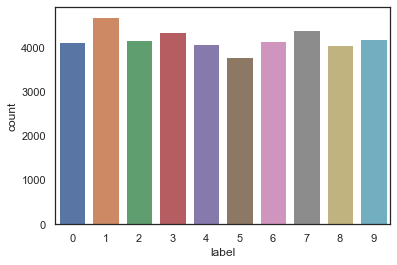

In [3]:
y_train = train["label"]
x_train = train.drop(labels = "label", axis = 1)
sns.countplot(y_train)
y_train.value_counts()

Check for null and missing values

In [4]:
x_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

Standardization

In [6]:
x_train = x_train/255
test = test/255

In [7]:
x_train.shape

(42000, 784)

In [8]:
# height = 28px, width = 28px , channel = 1
# MNIST images are gray scaled so it use only one channel.
x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Label encoding

In [9]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = to_categorical(y_train, num_classes = 10)

In [10]:
random = 2
# Split the train and the development set for the fitting
x_train,x_dev,y_train,y_dev = train_test_split(x_train, y_train, test_size = 0.1, train_size = 0.9, random_state = random)

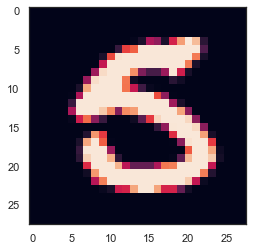

In [11]:
# example of showing an image
plt.imshow(x_train[4,:,:,0])

In [12]:
# set the CNN model
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [13]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

Data augmentation

In [15]:
data_aug = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,  # randomly rotate some training images by 10 degrees
        zoom_range = 0.1, # randomly Zoom by 10% some training images 
        width_shift_range=0.1,  # randomly shift images horizontally by 10% of the width
        height_shift_range=0.1,  # randomly shift images vertically by 10% of the height
        horizontal_flip=False,
        vertical_flip=False)


data_aug.fit(x_train)

In [16]:
# fit the data
history = model.fit_generator(data_aug.flow(x_train, y_train, batch_size=86), 
                              epochs=1, validation_data=(x_dev,y_dev),verbose=1,
                              steps_per_epoch=x_train.shape[0],callbacks=[learning_rate_reduction])

Epoch 1/1
37800/37800 [==============================] - 20096s 532ms/step - loss: 0.1101 - accuracy: 0.9751 - val_loss: 0.0879 - val_accuracy: 0.9871


C:\Users\yifeichen3\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


In [22]:
print(history.history)

{'val_loss': [0.08785262923377256], 'val_accuracy': [0.9871428608894348], 'loss': [0.11009736936674933], 'accuracy': [0.97505176], 'lr': [0.001]}


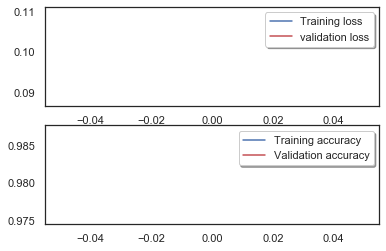

In [23]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

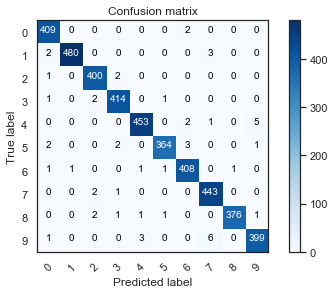

In [25]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_dev)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_dev,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))


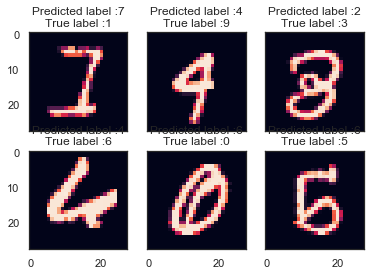

In [27]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = x_dev[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    # Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [28]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")